# MNIST Classifier

In [1]:
import torch
import torch.nn as nn

Build the model

In [2]:
def conv(ic:int, oc:int, k:int=5):
  layers = [nn.Conv2d(ic, oc, kernel_size=5), nn.MaxPool2d(2), 
            nn.ReLU(inplace=True)]
  return layers

class Flatten(nn.Module):
  def forward(self, x):
    return x.reshape(x.size(0), -1)

class Lenet(nn.Module):
  def __init__(self, nc:int=10, ic:int=1, ex:int=1, inhw:int=28):
    super().__init__()
    op = 5 if inhw == 32 else 4 # else assumes input size is 28 (for MNIST)
    layers = [*conv(ic, 6*ex), *conv(6*ex, 16*ex), Flatten(), 
              nn.Linear(16*op*op*ex, 120*ex), nn.Linear(120*ex, 84*ex), 
              nn.Linear(84*ex, nc)]
    self.net = nn.Sequential(*layers)

  def forward(self, x): return self.net(x)


net = Lenet()

Get the Dataset!

In [3]:
from torchvision import transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

root, bs  = './', 16

trf = T.Compose([
        T.RandomRotation(20),
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))
    ])

t = datasets.MNIST(root, train=True, download=True, transform=trf)
v = datasets.MNIST(root, train=False, download=True, transform=trf)
tloader = DataLoader(t, shuffle=True, batch_size=bs)
vloader = DataLoader(v, shuffle=True, batch_size=bs)

Define the Loss function and Optimizer

In [4]:
opti = optim.SGD(net.parameters(), lr=0.01)
crit = nn.CrossEntropyLoss()

Define the train function and train a MNIST Classifier

In [5]:
import torch.optim as optim

def train(net, crit, trl, val, epochs=5, lr=0.01, dev='cuda'):
  # Initialize the Optimizer
  opt = optim.SGD(net.parameters(), lr=lr)
  dev = 'cuda' if torch.cuda.is_available() and dev == 'cuda' else 'cpu'
  net.to(dev)
  for i in range(epochs):
    for data, labl in trl:
      data, labl = data.to(dev), labl.to(dev)
      #labl = (labl == bclf).unsqueeze(1).float()
      out = net(data.float())
      loss = crit(out, labl)
      #print (loss)
      opt.zero_grad()
      loss.backward()
      opt.step()
    
    with torch.no_grad():
      acc = 0; vloss = 0;
      for data, labl in val:
        data, labl = data.to(dev), labl.to(dev)
        #labl = (labl == bclf).unsqueeze(1).float()
        out = net(data.float())
        vloss += crit(out, labl).detach().cpu().numpy().item()
        plabl = torch.argmax(out, dim=1)
        #plabl = plabl.reshape(-1, 1).float()
        acc += (labl.float() == plabl.float()).detach().cpu().sum().numpy()
      
      vloss /= (len(val) * val.batch_size)
      acc /= (len(val) * val.batch_size)
      print ('Epoch {}/{} - Validation Loss {:.3f} - Accuracy - {:.3f}'.format(i+1, epochs,
        vloss, acc))

In [7]:
train(net, crit, tloader, vloader, epochs=5, lr=0.01)

Epoch 1/5 - Validation Loss 0.005 - Accuracy - 0.976
Epoch 2/5 - Validation Loss 0.004 - Accuracy - 0.978
Epoch 3/5 - Validation Loss 0.004 - Accuracy - 0.978
Epoch 4/5 - Validation Loss 0.004 - Accuracy - 0.978
Epoch 5/5 - Validation Loss 0.004 - Accuracy - 0.979


Let's viz!

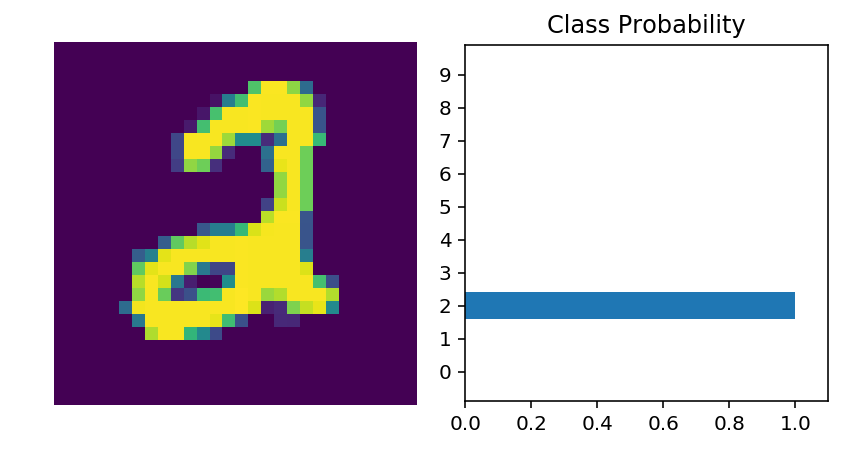

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torch.nn import functional as F
#import helper

# Test out your network!

dataiter = iter(vloader)
images, labels = dataiter.next()
img = images[0].unsqueeze(0)
# Convert 2D image to 1D vector
#img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(F.log_softmax(net.cpu()(img), dim=1))
#print (ps)

# Plot the image and probabilities
#helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Helper functions
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax